## L Layered Dynamic Neural Network

### Initialization

In [63]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt

#### Data-Set


In [64]:
X_train = np.loadtxt("D:\\Documents\\Data Science, ML\\Data Sets\\Binary Classification - Cat\\cat_train_x.csv", delimiter = ',')/255.00
Y_train = np.loadtxt("D:\\Documents\\Data Science, ML\\Data Sets\\Binary Classification - Cat\\cat_train_y.csv", delimiter = ',').reshape(1, X_train.shape[1])

X_test = np.loadtxt("D:\\Documents\\Data Science, ML\\Data Sets\\Binary Classification - Cat\\cat_test_x.csv", delimiter = ',')/255.00
Y_test = np.loadtxt("D:\\Documents\\Data Science, ML\\Data Sets\\Binary Classification - Cat\\cat_test_y.csv", delimiter = ',').reshape(1, X_test.shape[1])

#### Activation Functions

In [65]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def softmax(z):
    expZ = np.exp(z)
    return expZ/(np.sum(expZ, 0))

def relu(Z):
    return np.maximum(0,Z)

def tanh(x):
    return np.tanh(x)

def derivative_relu(x):
    return np.array(x > 0, dtype = 'float')

def derivative_tanh(x):
    return 1 - np.power(np.tanh(x), 2)

#### Random Data Set Image

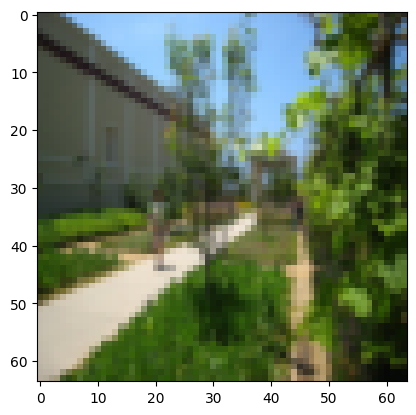

In [66]:
index = random.randrange(0, X_train.shape[1])
plt.imshow(X_train[:, index].reshape(64,64, 3))
plt.show()

### Model

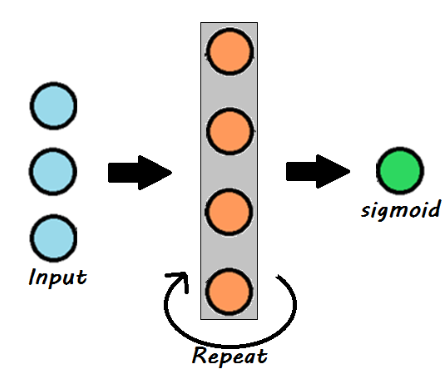

#### Initialize Training Parameters

* **Wl = np.random.randn(nl, nl-1)**
* **bl = np.zeroes((nl, 1))**

* *layer_details = number of neurons in each layer*
* *parameters = all Weights and Biases*

In [67]:
def initialize_parameters(layer_details):
    parameters = {}
    L = len(layer_details) 

    for i in range(1, L):
        parameters['W'+ str(i)] = np.random.randn(layer_details[i], layer_details[i-1]) / np.sqrt(layer_details[i-1]) # Divide by square-root to avoid Vanishing Gradient Problem in case of tanh activation 
        parameters['b'+ str(i)] = np.zeros((layer_details[i], 1))
    
    return parameters

###### Testing

In [68]:
# Checking shapes of Training Parameters
layer_details = [X_train.shape[0], 200, 300, 400, Y_train.shape[0]]
params = initialize_parameters(layer_details)

print("Shape of input layer: ", X_train.shape)
print("Shape of output layer: ", Y_train.shape)
print("------")

for i in range(1, len(layer_details)):
    print(f"Shape of W{i}: {params['W' + str(i)].shape}")
    print(f"Shape of b{i}: {params['b' + str(i)].shape}")
    if (i < len(layer_details)-1): print("------")
len(params)

Shape of input layer:  (12288, 209)
Shape of output layer:  (1, 209)
------
Shape of W1: (200, 12288)
Shape of b1: (200, 1)
------
Shape of W2: (300, 200)
Shape of b2: (300, 1)
------
Shape of W3: (400, 300)
Shape of b3: (400, 1)
------
Shape of W4: (1, 400)
Shape of b4: (1, 1)


8

#### Forward Propogation

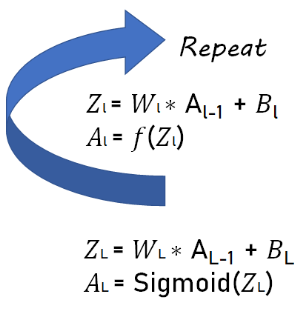

* Number of **Wi and bi** = Activation Layers (including i/p and o/p) - 1 = **L**
* Number of **Hiddent** Layers = (no.of Wis + bis)/2 - 1 = no. of Wi's - 1 = **L-1**
* Only for last layer we use: Sigmoid Activation (Binary Classification) | Softmax (Multi-class)
* *forward_parameters : Stores neuron information, Zi and Ai*

In [69]:
def forward_propogation(x, parameters, activation):
    forward_parameters = {}
    forward_parameters['A0'] = x
    L = len(parameters) // 2                # // 2 gives an integer    
   
    # Hidden Layers
    for i in range(1, L):                   # A0 .. AL-1
        Wi = parameters['W' + str(i)]
        bi = parameters['b' + str(i)]
        Zi = np.dot(Wi, forward_parameters['A' + str(i-1)]) + bi
        Ai = 0

        if activation == 'ReLU':
            Ai = relu(Zi)
        else:
            Ai = tanh(Zi)
        forward_parameters['A' + str(i)] = Ai
    
    # Last / Output Layer = AL
    ZL = np.dot(parameters['W' + str(L)], forward_parameters['A' + str(L-1)]) + parameters['b' + str(L)]
    if ZL.shape[0] == 1:                    # Binary Classificaiton
        forward_parameters['A' + str(L)] = sigmoid(ZL)
    else:                                   # Multi-Class Classification
        forward_parameters['A' + str(L)] = softmax(ZL)
    
    return forward_parameters['A' + str(L)], forward_parameters

###### Testing

In [70]:
# Testing 1
AL, forward_params = forward_propogation(X_train, params, 'ReLU')
len(forward_params) # Includes input and output layer

# Testing 2
for i in range(0, len(forward_params)):
    print(f"A{i}'s shape is: {forward_params['A' + str(i)].shape}\n")

A0's shape is: (12288, 209)

A1's shape is: (200, 209)

A2's shape is: (300, 209)

A3's shape is: (400, 209)

A4's shape is: (1, 209)



#### Cost Function
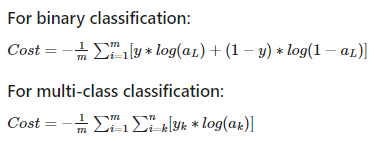

In [71]:
def cost_function(AL, y):
    m = y.shape[1]               # Number of observations

    if y.shape[0] == 1:          # Number of output classes
        cost = 1./m * (-np.dot(y,np.log(AL).T) - np.dot(1-y, np.log(1-AL).T))
    else:
        cost = -1./m * np.sum(y * np.log(AL))
        
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    return cost

#### Backward Propogation
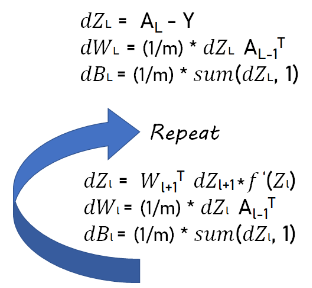

In [72]:
def backward_propogation(AL, y, parameters, forward_parameters, activation):
    gradients = {}
    L = len(parameters)//2
    m = AL.shape[1]
    
    gradients["dZ" + str(L)] = AL - y
    gradients["dW" + str(L)] = 1./m * np.dot(gradients["dZ" + str(L)],forward_parameters['A' + str(L-1)].T)
    gradients["db" + str(L)] = 1./m * np.sum(gradients["dZ" + str(L)], axis = 1, keepdims = True)
    
    for l in reversed(range(1, L)):  # reversed range
        if activation == 'tanh':
            gradients["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,gradients["dZ" + str(l+1)])*derivative_tanh(forward_parameters['A' + str(l)])
        else:
            gradients["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,gradients["dZ" + str(l+1)])*derivative_relu(forward_parameters['A' + str(l)])
            
        gradients["dW" + str(l)] = 1./m * np.dot(gradients["dZ" + str(l)],forward_parameters['A' + str(l-1)].T)
        gradients["db" + str(l)] = 1./m * np.sum(gradients["dZ" + str(l)], axis = 1, keepdims = True)  # W/o keepdims np.sum gives only one [] for column matrix

    return gradients

#### Update Parameters
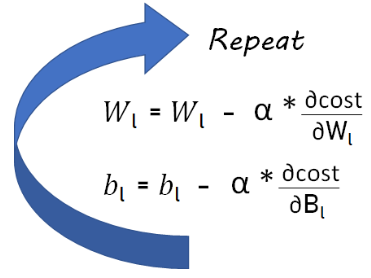
* *L = Number of Weights and Biases i.e. we want to go from W1,b1 to WL,bL*
* *Thus we do range(1, L+1)*

In [ ]:
def update_parameters (gradients, parameters, learning_rate):
    L = len(parameters)//2  
    for i in range(1, L+1): 
        parameters["W" + str(i)] = parameters["W" + str(i)] - learning_rate * gradients["dW" + str(i)]
        parameters["b" + str(i)] = parameters["b" + str(i)] - learning_rate * gradients["db" + str(i)]

    return parameters

### Predictions
